# Time-based test for blind SQL injections
Detectify challenge by Federico Barabas

## Problem interpretation and solving approach

Blind SQL injections are a kind of security attack that relies on runnig custom SQL instructions on a web application in order to retrieve data from its database.

The time-based test is a straightforward way to determine whether a given web application is susceptible to blind SQL injections.

The goal of this challenge is to come up with a test algorithm that can assess the vulnerability of a web appication with a false positive rate below 10^-6.

My approach:

1. Study the time response distributions for a single safe and a single vulnerable page for both a regular query and a query including a SLEEP instruction. 
    * Are the response times normally distributed? 
    * Do the regular and the delayed query produce similar distributions?
2. Based on the distribution, choose an apropriate statistical test to assess whether the distributions with and without the SLEEP query differ significantly. If they do, it means that that particular page is vulnerable.

3. Make the method generalizable to any webpage through sample size estimation (more details below).
  
4. Write a function that automates the testing process.

## URLs dataset testing log

All response times in seconds.

The csv file has two columns: url and response time

## Code

### Imports and functions definition

In [2]:
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import requests
import seaborn as sns
from multiprocessing import Pool
import scipy.stats as stats
import pandas as pd
from statsmodels.stats.power import tt_ind_solve_power

log_df = pd.DataFrame(columns=['url', 'time'])

In [3]:
sns.set_style('dark')
mpl.rcParams['figure.figsize'] = 1.2*np.array([8.0, 6.0])
mpl.rcParams['font.size'] = 1.2*12

### Auxiliary functions

In [4]:
def build_url(security='safe', page=1):
    """ 
    Build an URL from the security state.
    
    Parameters
    security (str): whether the page is susceptible to time-based SQL injections. Values: 'safe', 'vulnerable'
    page (int): page number
    """
    return 'http://localhost:5000/{}/{}/page?id=1'.format(security, page) 

In [5]:
def delay_url(url, seconds=4):
    """
    Given a URL, add a SLEEP SQL instruction to stop the database reading if it is susceptible to time-based SQL injections.
    
    Parameters
    url (str): original URL
    seconds (float): time intended for the delay
    """
    return url[:-1] + 'SLEEP({})'.format(seconds/5)

For reasons I could not understand, an instruction such as `SLEEP(x)` seems to in fact delay the response for `5*x` seconds. With this in mind, I wrote this function in a way that this correcting factor is taken into account and one should just input the real intended delay.

In [6]:
def request_time(url):
    """
    Single response time query to url. Output in seconds.
    """
    return requests.get(url).elapsed.total_seconds()

In [7]:
def get_times(pool, n, url):
    """
    Measure the response time to an URL several times. To save time, the requests are sent in a paralellized fashion using all available cores.
    
    Parameters:
    pool: initialized multiprocessing pool
    n: total number of times to be measured
    url: target URL
    """
    
    # Response times requests
    times = pool.map(request_time, [url] * n)

    # Data saving
    df = pd.DataFrame(data=np.array([[url]*n, times]).T, columns=['url', 'time'])
    
    return times, df

In [8]:
def sample_pvalue(nodelay, delay, i):
    """
    Takes a random subset of i elements from two lists and calculates the one-sided pvalue of an independent samples Student's T-test.
    
    Parameters
    nodelay, delay: input samples. The order matters because it is a one-sided test. The mean of `delay` should be greater than the mean of `nodelay`.
    i: sample size used for testing.
    """
    test = stats.ttest_ind(np.random.choice(delay, i), np.random.choice(nodelay, i))
    return 0.5*test.pvalue

### Time response distribution study

Goals
* Study the time response distribution. Is it a normal distribution or similar to it?
* How does the SLEEP query injection affect the distribution?

In [9]:
pool = Pool()

#### Time response distribution

In [10]:
url = build_url()
no_delays_safe, df1 = get_times(pool, 200, url)

log_df = pd.concat([log_df, df1], ignore_index=True)

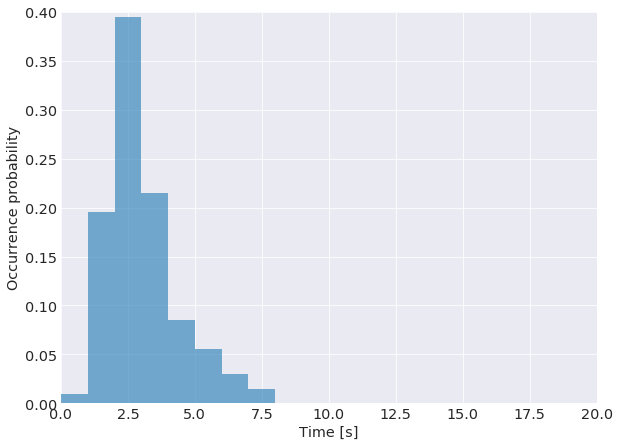

In [11]:
plt.hist(no_delays_safe, bins=20, alpha=0.6, density=True, range=(0, 20))
plt.grid()
plt.xlim(0, 20)
plt.ylim(0, 0.4)
plt.xlabel('Time [s]')
plt.ylabel('Occurrence probability')
plt.show()

* Not normally distributed but probably close enough to use the Student's T test for comparison between distributions.

#### Distribution with and without the time-based injection

In [12]:
url = build_url('vulnerable')
no_delays_vuln, df1 = get_times(pool, 200, url)
delays_vuln, df2 = get_times(pool, 200, delay_url(url))

log_df = pd.concat([log_df, df1, df2], ignore_index=True)

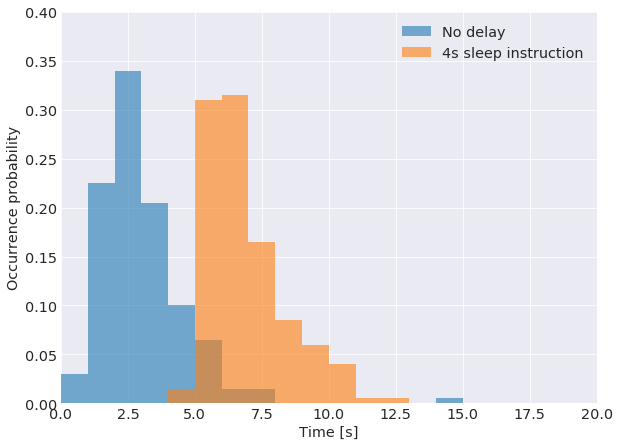

In [13]:
plt.hist(no_delays_vuln, bins=20, alpha=0.6, label='No delay', density=True, range=(0, 20))
plt.hist(delays_vuln, bins=20, alpha=0.6, label='4s sleep instruction', density=True, range=(0, 20))
plt.legend()
plt.grid()
plt.xlim(0, 20)
plt.ylim(0, 0.4)
plt.xlabel('Time [s]')
plt.ylabel('Occurrence probability')
plt.show()

* It is clear that the `SLEEP` SQL injection preserves the distribution shape, including the variance. This is also important for the assumptions of the Student's T test.

When we have two (or more) sets of measurements it is often the case that we want to know whether they come from the same distribution. That is, whether they are equivalent. Here, a positive answer would mean that the time-base injection has no effect and therefore the page is `safe`. Under the assumptions that

* the data follows a gaussian distribution
* both sets have the same variance
* the sets are independent with respect to each other,
then we can use the very famous Student's T test to decide. Given the challenge requisit of having a false positive rate of 10^-6, that is the pvalue we need to get from the Student's T test comparison between distributions. If the result is less than 10^-6, we can safely say that the original distributions are different and then that the page is `vulnerable`.

Let's look at how many samples we need to achieve that.

/home/federico/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3194: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/federico/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


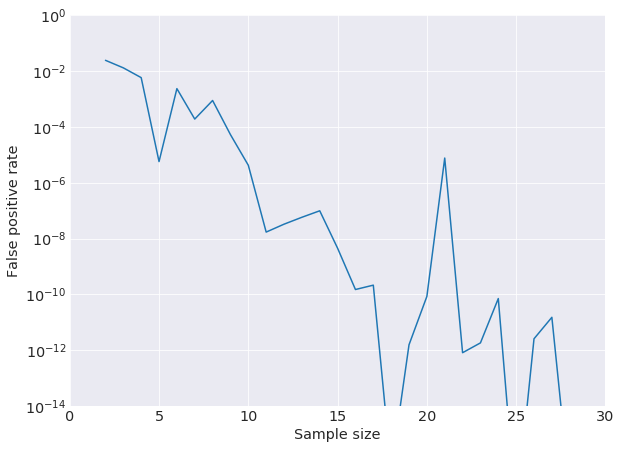

In [14]:
pvalues = [sample_pvalue(delays_vuln, no_delays_vuln, i) for i in range(len(delays_vuln))]

plt.plot(pvalues)
plt.xlim(0, 30)
plt.grid()
plt.ylim(0.00000000000001, 1)
plt.gca().set_yscale('log')
plt.xlabel('Sample size')
plt.ylabel('False positive rate')
plt.show()

We see here that the pvalue goes below 10^-6 around `n = 10`. We will use this in the algorithm as a first approximation of the needed sample size.

In [15]:
log_df.to_csv('challenge_dataset.csv')

## Algorithm

I tried to keep this simple.

1. Choose the page you want to test. Example url: `http://localhost:5000/vulnerable/1/page?id=1`.
2. Take 10 time response times from it. 
3. Measure this sample standard deviation and, using the t-test equations, get the amount of measurements that would be needed to achieve a false positive rate of 10^-6 with a fixed delay time of 4s.
4. If this number is greater than 10, ask more response times from the page until the number is reached.
5. Include a time-based SQL injection into the URL and get as many response times as we already have for the original url.
6. Calculate the pvalue from the Student's T comparison test between the two sets of times.
7. If this pvalue is below 10^-6, this means this particular URL is vulnerable. If not, it is safe.

### Example

In [27]:
url = build_url('vulnerable', 10)
print('URL: ', url)
delay_time = 4

URL:  http://localhost:5000/vulnerable/10/page?id=1


In [38]:
start = time.time()

# Get first 10 response times from URL
algo_nodelays = get_times(pool, 10, url)[0]

# Calculate the sample size needed for achieving a false positive rate of 10^-6
st_dev = np.std(algo_nodelays)
needed_n = int(np.ceil(tt_ind_solve_power(effect_size=delay_time/st_dev, alpha=2*10**(-6), power=0.95)))

# If needed, get additional response times from URL.
if needed_n > 10:
    algo_nodelays = algo_nodelays + get_times(pool, needed_n - 10, url)[0]

# Get as many response times from the URL with time injection
algo_delays = get_times(pool, needed_n, delay_url(url, delay_time))[0]

print('pvalue', 0.5*stats.ttest_ind(algo_delays, algo_nodelays[:needed_n]).pvalue)
print('Time elapsed: {:.1f} s'.format(time.time() - start))

pvalue 1.382134798249191e-08
Time elapsed: 35.2 s


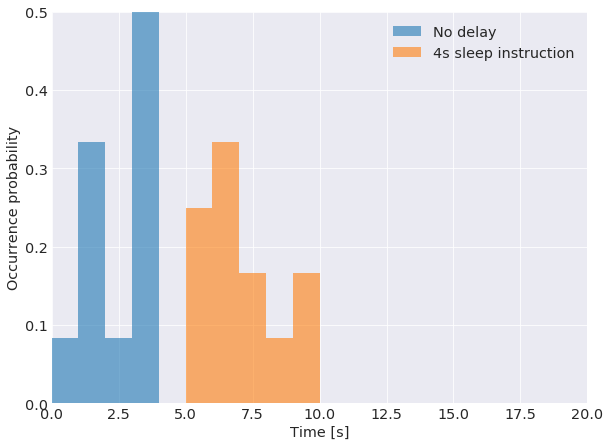

In [39]:
plt.hist(algo_nodelays, bins=20, alpha=0.6, label='No delay', density=True, range=(0, 20))
plt.hist(algo_delays, bins=20, alpha=0.6, label='4s sleep instruction', density=True, range=(0, 20))
plt.legend()
plt.grid()
plt.xlim(0, 20)
plt.ylim(0, 0.5)
plt.xlabel('Time [s]')
plt.ylabel('Occurrence probability')
plt.show()

This example achieved an ultra small pvalue in 35 s of testing.

### Test function

In [22]:
def security_test(url, delay_time=4, verbose=False):
    nodelays = get_times(pool, 10, url)[0]
    
    st_dev = np.std(nodelays)
    needed_n = int(np.ceil(tt_ind_solve_power(effect_size=delay_time/st_dev, alpha=2*10**(-6), power=0.95)))
    
    if verbose:
        print('needed_n', needed_n)
    
    if needed_n > 10:
        nodelays = nodelays + get_times(pool, needed_n - 10, url)[0]
    delays = get_times(pool, needed_n, delay_url(url, delay_time))[0]
    
    if verbose:
        print(np.mean(nodelays), np.mean(delays))
    
    return 0.5*stats.ttest_ind(delays, nodelays[:needed_n]).pvalue

### Test on several pages

In [23]:
vulnerable_pvalues = [security_test(build_url('vulnerable', i)) for i in range(1, 5)]

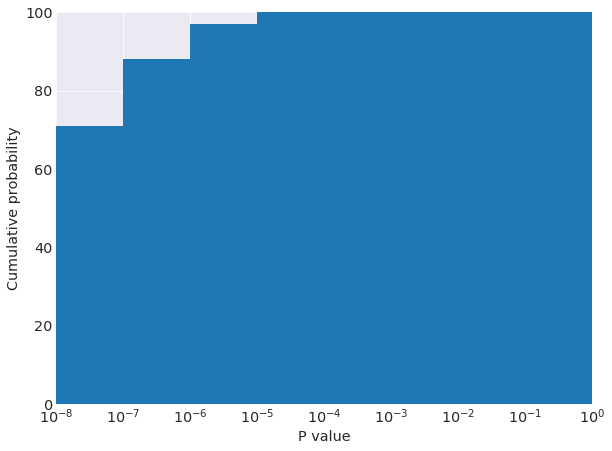

In [47]:
plt.hist(vulnerable_pvalues, bins=[0, 10**(-7), 10**(-6), 10**(-5), 10**(-4), 1], cumulative=True)
plt.xlim(10**(-8), 1)
plt.ylim(0, 100)
plt.gca().set_xscale('log')
plt.grid()
plt.xlabel('P value')
plt.ylabel('Cumulative probability')
plt.show()

In [20]:
100*(np.array(vulnerable_pvalues) < 10**(-6)).sum()/len(vulnerable_pvalues)

88.0

We see here that 88% of the tested vulnerable websites are correctly classified as such with a threshold of 10^(-6). Furthermore, there were no pvalues greater than 10^(-5). This means that the comparison with the `safe` pages should be very straightforward under these conditions. 

In [24]:
%timeit security_test(build_url('vulnerable', 10))

The slowest run took 4.24 times longer than the fastest. This could mean that an intermediate result is being cached.
1min 10s ± 39.9 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Room for improvement


### Performance on `safe` pages

No specific analysis was done to test the algorithm in `safe` pages as most definitely the probability of classifying any `safe` page as `vulnerable` with the current chosen delay for the injection is negligible. If this algorithm would be adapted for producting, this effectiveness should still be quantified.

### Time per test

The algorithm presented here uses a fixed delay time of 4 seconds. This was not optimized to reduce the testing time. A smaller delay time would require more sampling to achieve the same level of significance, but there could be an optimum sweet spot that reduces the time for each test. This should be studied to improve the algorithm.

The results from the previous section also suggest that it should be possible to both

* reduce the number of samples to speed up testing, and
* relax the 10^(-6) threshold to achive 100% identification of `vulnerable` pages. Using 10^(-5) instead would suffice.

These steps would dramatically reduce the time needed for each test.